In [1]:
import numpy as np
import pandas as pd

# Dataset

This dataset has quantified the fluorescence signal intensities from a protein labeling the centromeres of human chromosomes.  Each line of the data file corresponds to a single spot (centromere).  'intensity' is the intensity of the signal of the centromere label at that spot, 'C1_Intensity' is the intensity of the Chromosome7 FISH label at that spot, and 'C2_Intensity' is the intensity of the Chromosome11 FISH label at that spot.  There are ~40 spots per nucleus, you can identify the different nuclei by their 'file' label.  Within the 'file' name are keywords identifying whether this nucleus was treated with Palbo_ON or RO_ON cell cycle inhibitors.  

The goal of our analysis is to determine how variable our centromeric protein labeling is, and determine whether certain chromosomes tend to have more of the centromeric protein recruited to their centromeres.

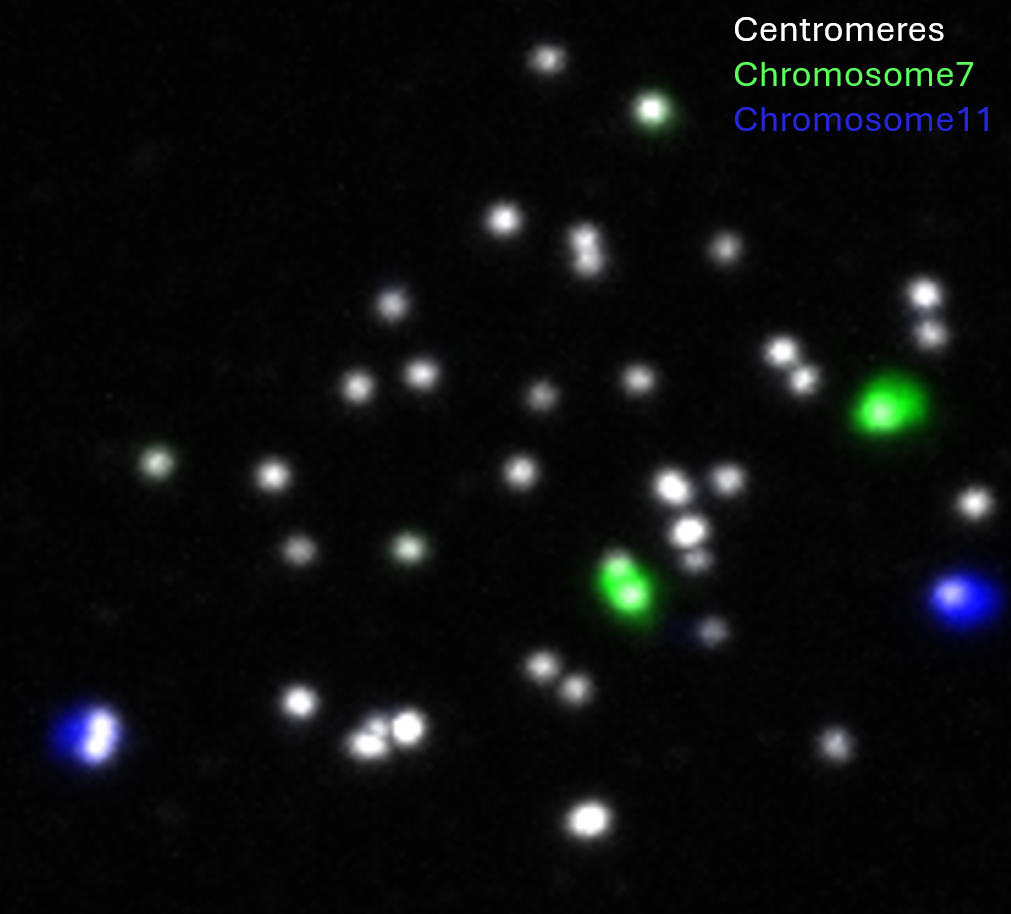

In [4]:
# DO NOT DELETE
from IPython.display import Image
Image(filename='Data/Centromeres.png', width=600)

# Part 1:  Preparing data

In [2]:
# DO NOT DELETE
df = pd.read_csv('https://www.dropbox.com/scl/fi/dm74f7o49wwmvy5tm4p5n/IF_FISH.csv?rlkey=c8c9j5q2jtf1itc0mip72wvzt&dl=1')

In [3]:
df

,centromere_index,intensity,file,C1_Intensity,C2_Intensity
0,0,412.566830,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,101,169
1,1,394.414900,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,114,194
2,2,385.563800,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,114,105
3,3,379.589080,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,105,117
4,4,374.373400,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,104,903
...,...,...,...,...,...
9356,24,144.699650,Cen7g11rFISH\RO_ON\IFISH010_008.tif,108,556
9357,25,126.950150,Cen7g11rFISH\RO_ON\IFISH010_008.tif,105,101
9358,26,120.408226,Cen7g11rFISH\RO_ON\IFISH010_008.tif,105,122
9359,27,129.366530,Cen7g11rFISH\RO_ON\IFISH010_008.tif,1912,144


### 1. Use the 'file' to create new columns:  one that contains the 'Label' (Cen7g11rFISH) and another that contains the treatment (Palbo_ON or RO_ON)

In [4]:
df['Label'] = df['file'].str.split('\\').str[0]
df['Treatment'] = df['file'].str.split('\\').str[1]
df

,centromere_index,intensity,file,C1_Intensity,C2_Intensity,Label,Treatment
0,0,412.566830,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,101,169,Cen7g11rFISH,Palbo_ON
1,1,394.414900,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,114,194,Cen7g11rFISH,Palbo_ON
2,2,385.563800,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,114,105,Cen7g11rFISH,Palbo_ON
3,3,379.589080,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,105,117,Cen7g11rFISH,Palbo_ON
4,4,374.373400,Cen7g11rFISH\Palbo_ON\IFISH001_000.tif,104,903,Cen7g11rFISH,Palbo_ON
...,...,...,...,...,...,...,...
9356,24,144.699650,Cen7g11rFISH\RO_ON\IFISH010_008.tif,108,556,Cen7g11rFISH,RO_ON
9357,25,126.950150,Cen7g11rFISH\RO_ON\IFISH010_008.tif,105,101,Cen7g11rFISH,RO_ON
9358,26,120.408226,Cen7g11rFISH\RO_ON\IFISH010_008.tif,105,122,Cen7g11rFISH,RO_ON
9359,27,129.366530,Cen7g11rFISH\RO_ON\IFISH010_008.tif,1912,144,Cen7g11rFISH,RO_ON


### 2. Use groupby and agg to find the number of rows (centromeres) per file (nucleus)

In [5]:
agged = df.groupby(['file']).agg({'intensity':len}).reset_index().rename(columns={'intensity':'spots'})


### 3. Merge this with the original df

In [ ]:
df = df.merge(agged, on=['file'])


### 4. Filter the dataframe so that only files with a number of centromeres less than 47 and greater than 36 are kept

In [6]:
df = df[df['spots']>36]
df = df[df['spots']<47]

# Part 2:  Exploring Data

In [7]:
# DO NOT DELETE
df = pd.read_csv('https://www.dropbox.com/scl/fi/ix4me19z011k3daud1l8w/homework4_p1.csv?rlkey=dywdn2wyl0qp0ukmwzm9f9t42&dl=1')

In [8]:
df.groupby(['Label', 'Treatment']).agg({'intensity': 'mean', 'C1_Intensity': 'mean', 'C2_Intensity': 'mean'}).reset_index()

,Label,Treatment,intensity,C1_Intensity,C2_Intensity
0,Cen7g11rFISH,Palbo_ON,348.309812,275.099571,1157.429894
1,Cen7g11rFISH,RO_ON,263.854585,203.803437,922.717508


### 1.  Create a sub_df that contains only elements of df for which treatment == Palbo_ON

In [9]:
sub_df = df[(df['Treatment']=='Palbo_ON') & (df['Label']=='Cen7g11rFISH')]


### 2.  Use groupby and agg to get the median value for 'intensity' for each file (nucleus).  Store this in agged_df

In [10]:
agged_df = sub_df.groupby(['file']).agg({'intensity': 'median'}).reset_index()

### 3.  Use sort_values to organize these largest to smallest.

In [11]:
agged_df.sort_values(by='intensity', ascending=False).to_csv('Data/homework4_p2.csv')

It should look something like this:

In [12]:
# DO NOT DELETE
pd.read_csv('https://www.dropbox.com/scl/fi/86ccqt1uio9ofvrsbqmu2/homework4_p2.csv?rlkey=8zo8q9fbbf046uvk1i96ocabq&dl=1')

,Unnamed: 0,file,intensity
0,71,Cen7g11rFISH\Palbo_ON\IFISH009_003.tif,627.232300
1,62,Cen7g11rFISH\Palbo_ON\IFISH008_002.tif,591.331050
2,75,Cen7g11rFISH\Palbo_ON\IFISH009_007.tif,549.476925
3,67,Cen7g11rFISH\Palbo_ON\IFISH008_008.tif,548.165650
4,87,Cen7g11rFISH\Palbo_ON\IFISH010_009.tif,541.443900
...,...,...,...
100,99,Cen7g11rFISH\Palbo_ON\IFISH011_009.tif,169.078310
101,103,Cen7g11rFISH\Palbo_ON\IFISH011_016.tif,167.992385
102,51,Cen7g11rFISH\Palbo_ON\IFISH007_002.tif,166.704710
103,21,Cen7g11rFISH\Palbo_ON\IFISH003_005.tif,165.365495


# Part 3:  Normalizing Intensities by File

So it looks like even within one treatment/labeling combination that we have huge variability in the IF intensities between different nucleii.  So it would be nice to go back to our original df, and create a new column that normalizes the intensity for each centromere by the median value for the file that it is in.

We have the medians for each file from above, but that was only for Palbo_ON.

### 1.  Make a new df called median_df which finds the median value of intensity per file for our entire original df using groupby/agg.  

Make sure you use .rename to change the name of the column from 'intensity' to 'median_intensity' to save ourselves trouble later.

In [13]:
median_df = df.groupby(['file']).agg({'intensity': 'median'}).reset_index().rename(columns={'intensity': 'median_intensity'})
median_df

,file,median_intensity
0,Cen7g11rFISH\Palbo_ON\IFISH001_001.tif,289.840700
1,Cen7g11rFISH\Palbo_ON\IFISH001_002.tif,437.889250
2,Cen7g11rFISH\Palbo_ON\IFISH001_003.tif,366.066010
3,Cen7g11rFISH\Palbo_ON\IFISH001_004.tif,397.297200
4,Cen7g11rFISH\Palbo_ON\IFISH001_005.tif,314.844540
...,...,...
147,Cen7g11rFISH\RO_ON\IFISH009_006.tif,187.475420
148,Cen7g11rFISH\RO_ON\IFISH009_007.tif,271.086270
149,Cen7g11rFISH\RO_ON\IFISH009_009.tif,234.550485
150,Cen7g11rFISH\RO_ON\IFISH010_005.tif,256.505700


### 2. Merge the median_df with our original df, and store the value back into df.  

Note: if you run this cell multiple times it will not work, as the columns you are trying to add will already exist and it will keep adding duplicate columns with weird names.

In [14]:
df = df.merge(median_df, on='file')

What have we done here?  median_df only has an entry for each FILE, whereas df has an entry for each CENTROMERE (and there are about 40 centromeres per file).  When we merge, pandas is smart enough to realize that it should duplicate the median entries for every row that corresponds to that file which is very handy.

### 3. Define a new column:  normalized_intensity, that takes each centromere's intensity and divides by its file's median_intensity.

In [15]:
df['normalized_intensity'] = df['intensity'] / df['median_intensity']

### 4. Now sort our df by normalized_intensity to look at the distribution.

In [16]:
df.groupby(['file']).agg({'normalized_intensity': 'std'}).reset_index().sort_values(by='normalized_intensity', ascending=False)

,file,normalized_intensity
41,Cen7g11rFISH\Palbo_ON\IFISH006_002.tif,0.754162
79,Cen7g11rFISH\Palbo_ON\IFISH009_013.tif,0.649652
133,Cen7g11rFISH\RO_ON\IFISH006_003.tif,0.483186
116,Cen7g11rFISH\RO_ON\IFISH003_005.tif,0.480259
118,Cen7g11rFISH\RO_ON\IFISH003_009.tif,0.472613
...,...,...
93,Cen7g11rFISH\Palbo_ON\IFISH010_017.tif,0.191571
98,Cen7g11rFISH\Palbo_ON\IFISH011_007.tif,0.181660
72,Cen7g11rFISH\Palbo_ON\IFISH009_004.tif,0.175993
78,Cen7g11rFISH\Palbo_ON\IFISH009_012.tif,0.156349


Should look something like this:

In [17]:
#  DO NOT DELETE
pd.read_csv('https://www.dropbox.com/scl/fi/c5qw3q4cg5uolnz2dv102/homework4_p3.csv?rlkey=6zindzalx6h35dnu0udlln6m6&dl=1')

,Unnamed: 0,file,normalized_intensity
0,41,Cen7g11rFISH\Palbo_ON\IFISH006_002.tif,0.754162
1,79,Cen7g11rFISH\Palbo_ON\IFISH009_013.tif,0.649652
2,133,Cen7g11rFISH\RO_ON\IFISH006_003.tif,0.483186
3,116,Cen7g11rFISH\RO_ON\IFISH003_005.tif,0.480259
4,118,Cen7g11rFISH\RO_ON\IFISH003_009.tif,0.472613
...,...,...,...
147,93,Cen7g11rFISH\Palbo_ON\IFISH010_017.tif,0.191571
148,98,Cen7g11rFISH\Palbo_ON\IFISH011_007.tif,0.181660
149,72,Cen7g11rFISH\Palbo_ON\IFISH009_004.tif,0.175993
150,78,Cen7g11rFISH\Palbo_ON\IFISH009_012.tif,0.156349


It looks like we have a huge variation in the normalized intensity of the centromeres. 

# Part 4:  Finding chromosome 7's centromeres

If we go back to our df we see we have two extra intensities:  C1_Intensity and C2_Intensity.  These are FISH intensities.  For each file, there should be two really bright C1_Intensity values where the centromere comes from the labeled chromosome, and the rest much lower signal intensity as the centromere does not happen to overlap with a labeled chromosome.

### 1. Sort on 'file' and 'C1_intensity' with ascending=False argument to see if the top two values of C1_Intensity are very different from the others. 

We can quickly check by using df.sort_values().  This takes an argument "by" that can be a list of columns.  Like excel, it will sort first on the first column provided and then on the second column.  

 To view more than a few rows, you can use .head(50)

In [19]:
df.sort_values(by=['file', 'C1_Intensity'], ascending=False).head(50)

,Unnamed: 0,centromere_index,intensity,file,C1_Intensity,C2_Intensity,Label,Treatment,spots,median_intensity,normalized_intensity
6275,9316,25,263.56310,Cen7g11rFISH\RO_ON\IFISH010_007.tif,2839,113,Cen7g11rFISH,RO_ON,41,277.52692,0.949685
6268,9309,18,278.29733,Cen7g11rFISH\RO_ON\IFISH010_007.tif,1824,112,Cen7g11rFISH,RO_ON,41,277.52692,1.002776
6261,9302,11,315.17990,Cen7g11rFISH\RO_ON\IFISH010_007.tif,387,124,Cen7g11rFISH,RO_ON,41,277.52692,1.135673
6263,9304,13,312.23175,Cen7g11rFISH\RO_ON\IFISH010_007.tif,350,110,Cen7g11rFISH,RO_ON,41,277.52692,1.125050
6282,9323,32,223.97304,Cen7g11rFISH\RO_ON\IFISH010_007.tif,239,108,Cen7g11rFISH,RO_ON,41,277.52692,0.807032
6288,9329,38,185.79305,Cen7g11rFISH\RO_ON\IFISH010_007.tif,145,132,Cen7g11rFISH,RO_ON,41,277.52692,0.669460
6287,9328,37,191.36500,Cen7g11rFISH\RO_ON\IFISH010_007.tif,116,510,Cen7g11rFISH,RO_ON,41,277.52692,0.689537
6255,9296,5,384.92150,Cen7g11rFISH\RO_ON\IFISH010_007.tif,114,106,Cen7g11rFISH,RO_ON,41,277.52692,1.386970
6286,9327,36,197.94643,Cen7g11rFISH\RO_ON\IFISH010_007.tif,113,111,Cen7g11rFISH,RO_ON,41,277.52692,0.713251
6262,9303,12,319.69037,Cen7g11rFISH\RO_ON\IFISH010_007.tif,111,970,Cen7g11rFISH,RO_ON,41,277.52692,1.151926


### 2. Use groupby and rank to create a new column in df that lists the rank of intensity C1_Intensity.  We want the brightest object to be rank 1, so ascending=False is a good idea.

In [20]:
df['C1_Ranked'] = df.groupby(['file'])['C1_Intensity'].rank(ascending=False)

### 3. Create a new column 'chr7_pos' that is True if C1_Ranked is a 1 or 2, and False otherwise

In [21]:
df['chr7_pos'] = df['C1_Ranked'] <= 2

### 4. What do you think this code is doing?

In [22]:
# DO NOT DELETE
df['Random'] = np.random.rand(len(df))
df['Random_Ranked'] = df.groupby(['file'])['Random'].rank(ascending=False)
df['random_pos'] = df['Random_Ranked'] <= 2

...

How things should look:

In [23]:
# DO NOT DELETE
pd.read_csv('https://www.dropbox.com/scl/fi/zx8z2w8bnz7xeg81y1gi1/homework4_p4.csv?rlkey=52gxtbflpjt1jegd3equmwtef&dl=1')

,Unnamed: 0.1,Unnamed: 0,centromere_index,intensity,file,C1_Intensity,C2_Intensity,Label,Treatment,spots,median_intensity,normalized_intensity,C1_Ranked,chr7_pos,Random,Random_Ranked,random_pos
0,0,47,0,620.29140,Cen7g11rFISH\Palbo_ON\IFISH001_001.tif,124,4437,Cen7g11rFISH,Palbo_ON,41,289.84070,2.140111,12.0,False,0.983128,3.0,False
1,1,48,1,501.66000,Cen7g11rFISH\Palbo_ON\IFISH001_001.tif,164,117,Cen7g11rFISH,Palbo_ON,41,289.84070,1.730813,11.0,False,0.225321,35.0,False
2,2,49,2,481.91653,Cen7g11rFISH\Palbo_ON\IFISH001_001.tif,106,191,Cen7g11rFISH,Palbo_ON,41,289.84070,1.662694,30.0,False,0.462221,25.0,False
3,3,50,3,452.32898,Cen7g11rFISH\Palbo_ON\IFISH001_001.tif,106,266,Cen7g11rFISH,Palbo_ON,41,289.84070,1.560612,30.0,False,0.773706,14.0,False
4,4,51,4,446.39993,Cen7g11rFISH\Palbo_ON\IFISH001_001.tif,103,289,Cen7g11rFISH,Palbo_ON,41,289.84070,1.540156,37.5,False,0.540164,23.0,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6286,6286,9327,36,197.94643,Cen7g11rFISH\RO_ON\IFISH010_007.tif,113,111,Cen7g11rFISH,RO_ON,41,277.52692,0.713251,9.0,False,0.410160,21.0,False
6287,6287,9328,37,191.36500,Cen7g11rFISH\RO_ON\IFISH010_007.tif,116,510,Cen7g11rFISH,RO_ON,41,277.52692,0.689537,7.0,False,0.063371,39.0,False
6288,6288,9329,38,185.79305,Cen7g11rFISH\RO_ON\IFISH010_007.tif,145,132,Cen7g11rFISH,RO_ON,41,277.52692,0.669460,6.0,False,0.485058,14.0,False
6289,6289,9330,39,184.02896,Cen7g11rFISH\RO_ON\IFISH010_007.tif,109,109,Cen7g11rFISH,RO_ON,41,277.52692,0.663103,17.0,False,0.597339,10.0,False


# Part 5:  Ranking IF Intensity

In [24]:
# DO NOT DELETE
df = pd.read_csv('https://www.dropbox.com/scl/fi/zx8z2w8bnz7xeg81y1gi1/homework4_p4.csv?rlkey=52gxtbflpjt1jegd3equmwtef&dl=1')

### 1. Do a similar groupby rank operation for the 'intensity' channel:  create a new column 'IF_Ranked' that gives the ranking of that centromere's IF intensity within that file (nucleus)

In [25]:
df['IF_Ranked'] = df.groupby(['file'])['intensity'].rank(ascending=False)

There are two haplotypes for each chromosome, and they may have different CenpA enrichment.  Let's find for each file the centromere that is the brightest IF_Ranked that is chr7_pos (remember, highest ranking means lowest value:  1 means brightest, 2 second brightest etc.)


### 2.  Make a sub_dataframe that only contains the centromeres that are chr7_pos


In [26]:
sub_df = df[df['chr7_pos']]

### 2.  For this datafframe, use groupby and agg to find the IF intensity rank (you are looking for the smallest one, so 'min' would be optimal)


In [27]:
agged_df = sub_df.groupby(['file']).agg({'IF_Ranked': 'min'}).reset_index()

### 3.  For this agged dataframe, calculate the median value for the IF intensity rank

In [28]:
median_val = agged_df['IF_Ranked'].median()
print(median_val)

7.0


Our brighter chromosome7 haplotype is usually 7th out of 40 in terms of its cenpA signal, but what would happen if we chose two random chromosomes and chose the brigher of the two, what rank could we expect?

### 4.  Do all of this again for 'random_pos' rows.

In [29]:
sub_df = df[df['random_pos']]
agged_df = sub_df.groupby(['file']).agg({'IF_Ranked': 'min'}).reset_index()
median_val = agged_df['IF_Ranked'].median()
print(median_val)

13.0


# Bonus:  Do Statistical Analysis

We calculated the median, but instead let's take the list of values associated with the brightest chr7_pos centromeres and do a statistical test vs the random_values.



In [30]:
chr7_values = df[df['chr7_pos']].groupby(['file']).agg({'IF_Ranked': 'min'}).reset_index()['IF_Ranked'].values
random_values = df[df['random_pos']].groupby(['file']).agg({'IF_Ranked': 'min'}).reset_index()['IF_Ranked'].values

In [31]:
# DO NOT DELETE
import scipy.stats as stats

stats.mannwhitneyu takes two lists of values and computes a pvalue.  Try this for our dataset.

In [32]:
stats.mannwhitneyu(chr7_values, random_values)

MannwhitneyuResult(statistic=7252.0, pvalue=1.9286348129544474e-08)